# Appointment Duration 

###  Aim: Make an approximation of appointment time by ICB and staff type that we can use in discrete event simulation?
- Find all binneed appointments by area
- Fit a probability distribution function
- Export to Yaml file

## Library imports

In [16]:
import numpy as np
import pandas as pd
from typing import Optional, Iterable


from scipy.stats import poisson, expon, lognorm
from scipy.optimize import minimize

# custom imports
from schemas import DataCatalog
import constants as const

## Notebook constants

In [10]:
GP_APPOINTMENTS_CATALOG_INDEX = -2
HIST_BIN_EDGES = [1, 6, 11, 16, 21, 31, 60]

##

In [8]:
data_catalog = DataCatalog.load_from_yaml("data_catalog.yaml")

In [11]:
appointments_df = data_catalog.single_data_sources[GP_APPOINTMENTS_CATALOG_INDEX].load()

appointments_df = (
    appointments_df # select only the columns we need, and remove unknown
    .loc[(appointments_df['SUB_ICB_LOCATION_CODE'].isin(const.SUB_ICB_CODES.keys())) & (appointments_df['ACTUAL_DURATION'] != "Unknown / Data Quality")]
    .assign(
        Alliance=appointments_df['SUB_ICB_LOCATION_CODE'].map(
            const.SUB_ICB_CODES), # add the alliance column
        Date=pd.to_datetime(appointments_df['Appointment_Date'], format='%d%b%Y')) # convert the date column to datetime
        # drop the columns we don't need
    .drop(columns=['SUB_ICB_LOCATION_CODE', 'SUB_ICB_LOCATION_ONS_CODE', 'SUB_ICB_LOCATION_NAME', 'ICB_ONS_CODE', 'REGION_ONS_CODE', 'Appointment_Date']))
appointments_df.head()

,ACTUAL_DURATION,COUNT_OF_APPOINTMENTS,Alliance,Date
195134,6-10 Minutes,1825,Ipswich & East Suffolk,2021-12-01
195135,21-30 Minutes,752,Ipswich & East Suffolk,2021-12-01
195136,16-20 Minutes,786,Ipswich & East Suffolk,2021-12-01
195137,31-60 Minutes,456,Ipswich & East Suffolk,2021-12-01
195138,11-15 Minutes,1253,Ipswich & East Suffolk,2021-12-01


In [12]:
appointments_binned_df = (appointments_df
                          .groupby(['Alliance', pd.Grouper(key='Date',freq='BA-MAR',label='right'),'ACTUAL_DURATION'])
                          .sum()
                          .reset_index()
                          .rename(columns={'Date':'financial_year'}).replace({"1-5":"01-05","6-10":"06-10"})
                          .assign(financial_year=lambda df: df['financial_year'].dt.year-1))

appointments_binned_df.head()

def strip_bins(input_string):
    out_string =  input_string.replace(" Minutes", "")
    return tuple((int(i) for i in out_string.split("-")))

appointments_binned_df['left_bin'], appointments_binned_df['right_bin'] = zip(*appointments_binned_df['ACTUAL_DURATION'].map(strip_bins))
appointments_binned_df['middle_bin'] = (appointments_binned_df['right_bin'] + appointments_binned_df['left_bin']) / 2  
appointments_binned_df.head()

,Alliance,financial_year,ACTUAL_DURATION,COUNT_OF_APPOINTMENTS,left_bin,right_bin,middle_bin
0,Ipswich & East Suffolk,2021,1-5 Minutes,140934,1,5,3.0
1,Ipswich & East Suffolk,2021,11-15 Minutes,106449,11,15,13.0
2,Ipswich & East Suffolk,2021,16-20 Minutes,67949,16,20,18.0
3,Ipswich & East Suffolk,2021,21-30 Minutes,65468,21,30,25.5
4,Ipswich & East Suffolk,2021,31-60 Minutes,40643,31,60,45.5


In [14]:
distribution_data = {}

for index, row in appointments_binned_df.iterrows():
    uniform_dist = np.random.randint(low=row['left_bin'],high=row['right_bin']+1,size=row['COUNT_OF_APPOINTMENTS'])

    alliance = row['Alliance']
    year = row['financial_year']
 
    if not distribution_data.get(alliance, None):
        distribution_data[alliance] = {}# add dict entry

    # check year entry
    dist_array = distribution_data.get(alliance).get(year,None) 

    if dist_array is None:
        distribution_data[alliance][year] =  uniform_dist
    else:
        distribution_data[alliance][year] = np.append(dist_array,uniform_dist)




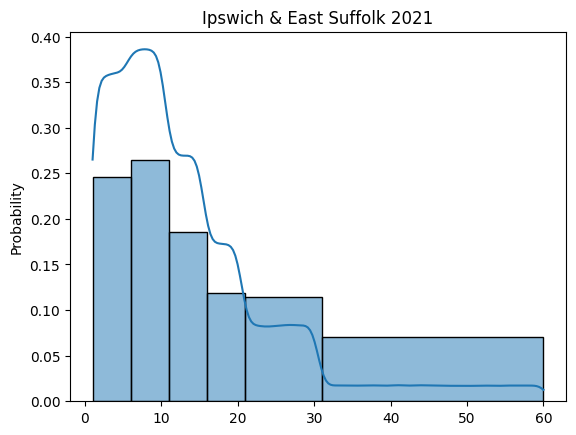

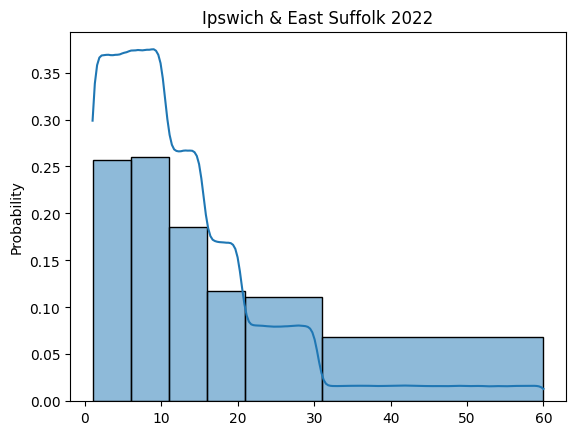

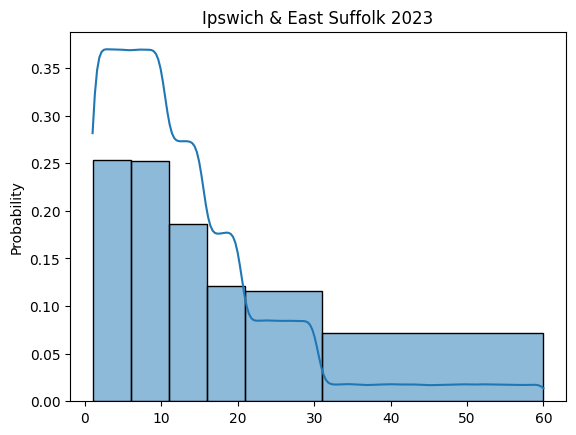

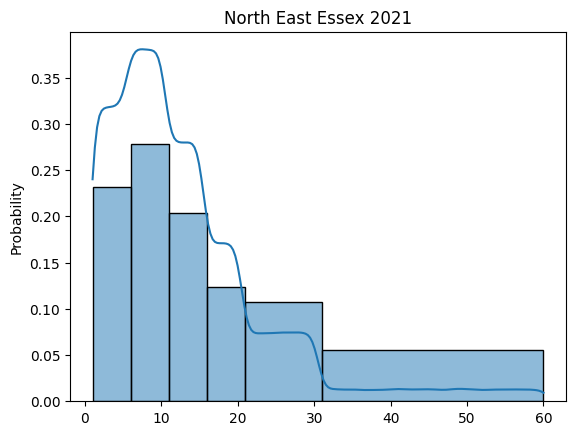

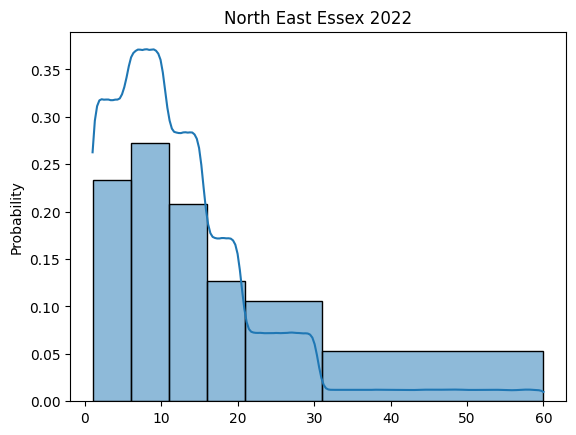

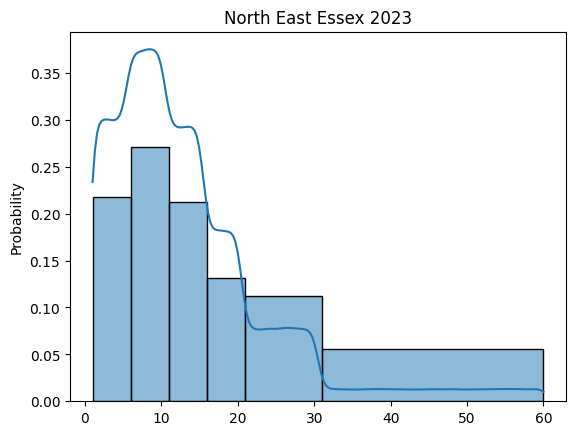

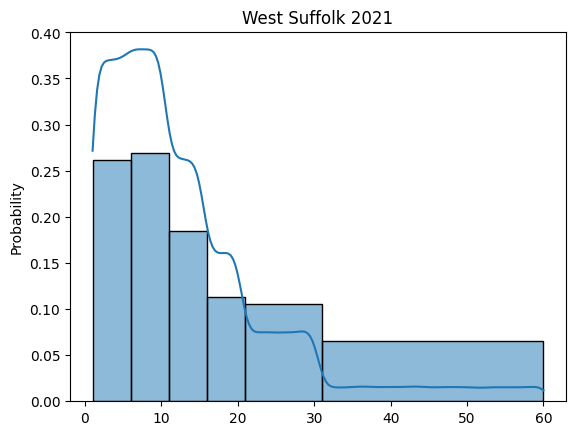

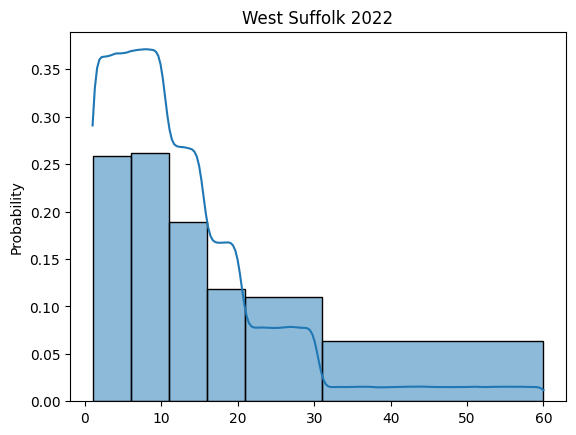

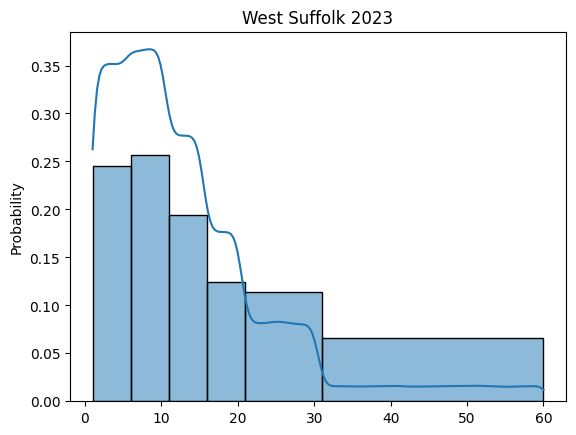

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

for alliance, dataset in distribution_data.items():
    for year, array in dataset.items():
        ax = sns.histplot(array, kde=True, bins=HIST_BIN_EDGES,stat='probability')
        ax.set_title(f"{alliance} {year}")
        plt.show()


In [ ]:



def histogram_error(params, true_hist):
    true_hist_result = true_hist[0]
    hist_bins = true_hist[1]
    dist_guess = lognorm.rvs(*params, size=sum(true_hist_result))
    hist_guess = np.histogram(dist_guess, bins=hist_bins)[0]
    return sum(abs(true_hist_result-hist_guess))



dist_properties = {k:{} for k in distribution_data.keys()}

# minimize the negative log-Likelihood
for alliance, yearly_data in distribution_data.items():
    for year, data_array in yearly_data.items():
        hist_result = np.histogram(data_array, HIST_BIN_EDGES)
        print(f"{alliance} {year}")
        result = minimize(histogram_error,  # function to minimize
                        x0=np.ones(3),            # start values sigma loc, scale
                        args=(hist_result,),    # additional arguments for function
                        method='Powell',     # minimization method, see docs
                        bounds=((0.0,10),(-20,20),(0,30))        
                        )
        dist_properties[alliance][year] = dict(zip(["s","loc","scale"], result.x))
        print(result)

In [ ]:
for alliance, dataset in distribution_data.items():
    df =pd.DataFrame(dataset).head()

In [ ]:
 dist_properties[alliance][year]

In [ ]:
ax = sns.histplot(lognorm.rvs(*result.x, size=200000, ), bins=HIST_BIN_EDGES,stat='probability')
ax.set_title(f"{alliance} {year}")